# Classifying Presense of Heart Disease  

### DSCI 100 004 Group 24 Proposal

## Preliminary Exploratory Data Analysis

### Installation

Before beginning the analysis the library `cowplot` must be installed. To install the library run the install cell below.

In [1]:
install.packages("cowplot") 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Libraries

Next we will import the libraries `tidyverse`, `tidymodels`, `dplyr`, `repr`, and 
the previously installed `cowplot`. 

These libraries will be used to read, clean, split, summarize, and visualize the data set. 

In [2]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### Reading Data

The data is sourced from a UC Irvine Machine Learning Repository, found here https://archive.ics.uci.edu/dataset/45/heart+disease.

The relevant files have been add to this repository's `data` directory and pushed to GitHub. This file will read 
the data file from the GitHub URL to the raw data. 


In [3]:
# Create list of column names found in data/heart-disease.names
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# Read in data
dataset <- read_delim("https://raw.githubusercontent.com/tamzeedq/dsci-100_group_project/main/data/processed.cleveland.data", delim = ",", col_names = column_names)
head(dataset, 5) # Preview first 5 rows

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### Tidying/Cleaning the Data

Columns `ca` and `thal` are the only columns to have missing data, and since they are not relevant to our analysis we'll drop these two columns. Some column headers are also unclear, so we'll update the names that are relevant to our analysis to improve readability. Lastly, we will convert the columns representing chest pain type (`cp_type`) and presence of heart disease (`presence`) from numbers to factors. This is because they are both categorical variables that are being classified with correlated numbers; the columns don't actually represent a range of numbers.


In [4]:
updated_column_names <- c("age", "sex", "cp_type", "rest_bps", "chol", "fbs", "restecg", "max_heart_rate", "exang", "oldpeak", "slope", "ca", "thal", "presence")

colnames(dataset) <- updated_column_names # Updated the column names
updated_dataset <- dataset |>
            select(-ca, -thal) |> # Select every column except for ca and thal
            mutate(cp_type = as_factor(cp_type), presence = as_factor(presence)) # Convert column datatypes

head(updated_dataset, 5) # Preview first 5 rows

age,sex,cp_type,rest_bps,chol,fbs,restecg,max_heart_rate,exang,oldpeak,slope,presence
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0
67,1,4,160,286,0,2,108,1,1.5,2,2
67,1,4,120,229,0,2,129,1,2.6,2,1
37,1,3,130,250,0,0,187,0,3.5,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0


### Split the Data

The updated data set is split into a training set and testing set, 75% of the data will be used to create a training set while the remaining 25% will be used to create a testing data set.


In [5]:
data_split <- initial_split(updated_dataset, prop = 0.75, strata = presence)  
training_data <- training(data_split)   
testing_data <- testing(data_split)

### Summarize the Data

We will do two things to summarize the training data set. First, we will look at the count of rows for each category of the variable we wish to predict(`presence`). Second, we will look at the mean of the variables that we want to use to predict for `presence`: `age`, `rest_bps`, `chol`, `max_heart_rate`. 

**Note**: Although we want to use chest pain type (`cp_type`) as one of our predictor variables, it is a categorical variable therefore a mean value can not be found for it and won't be included in the mean table.  

Let's start with finding the count of different categories for our response variable.

In [6]:
presence_count <- training_data |>
                group_by(presence) |>
                summarize(count = n())
presence_count

presence,count
<fct>,<int>
0,123
1,41
2,27
3,26
4,9


Finding the means of our quantitative predictor variables.

In [7]:
variable_means <- training_data |>
summarize(mean_age=mean(age), mean_rest_bps=mean(rest_bps), mean_chol=mean(chol), mean_max_rate=mean(max_heart_rate))

variable_means

mean_age,mean_rest_bps,mean_chol,mean_max_rate
<dbl>,<dbl>,<dbl>,<dbl>
54.41593,132.8982,250.7566,150.7478


### Plotting the Data

Due to having multiple predictor variables, creating a plot with all of our predictor variables together would make for an unclear plot. So below is a scatter plot proving an example of a plot to visualize the association between 3/5 of our predictor variables. The graph compares age and cholesterol on the x and y axis, and is classified by shapes that relate to different chest pains. The different colors represent the different classifications for our response variable (`presence`).

Below the scatter plot are histograms to demonstrate the distribution of data that is being representing by our predictor variables in the training data set.

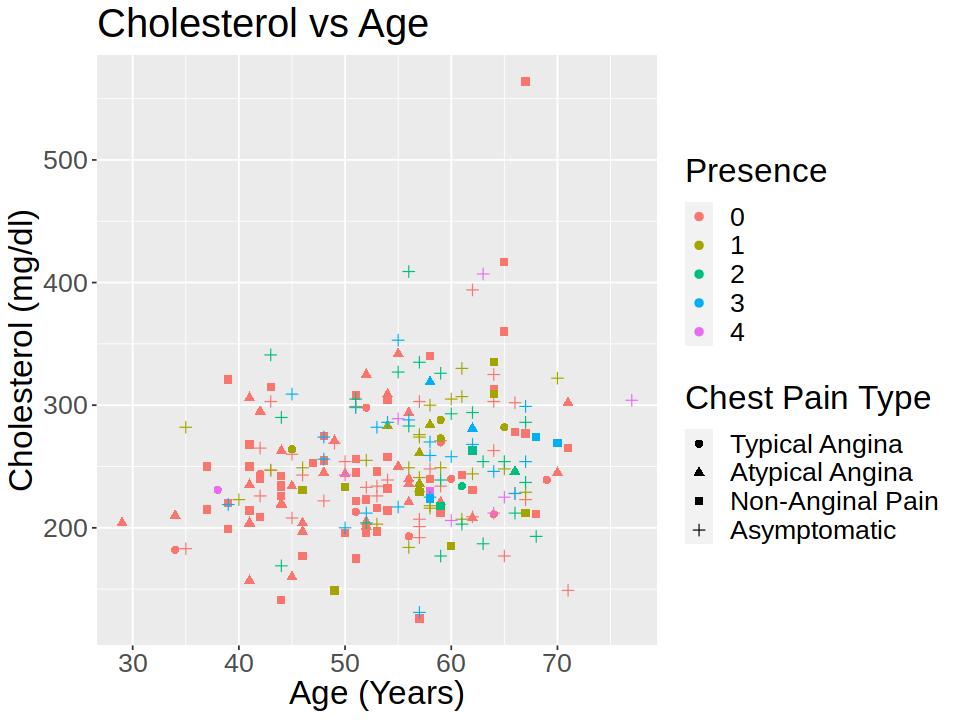

In [10]:
options(repr.plot.width = 8, repr.plot.height = 6)


chest_pain_labels <- c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic")

age_chol_plot <- training_data |>
    ggplot(aes(x = age, 
               y = chol, 
               colour = presence,
               shape = factor(cp_type, labels = chest_pain_labels))) +
    labs(x = "Age (Years)",
         y = "Cholesterol (mg/dl)",
         colour = "Presence",
         shape = "Chest Pain Type") +
    geom_point(size = 2) +
    ggtitle("Cholesterol vs Age") +
    theme(text = element_text(size = 20))

age_chol_plot

Distribution histograms

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


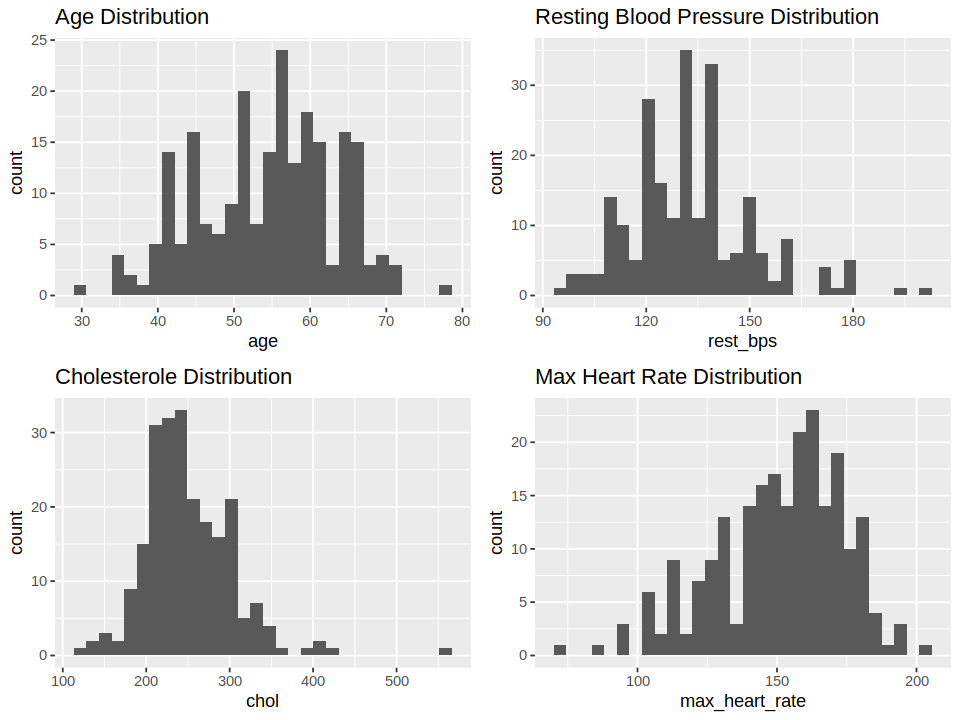

In [9]:
age_hist <- training_data |>
        ggplot(aes(x = age)) +
        geom_histogram() +
        ggtitle("Age Distribution")

bps_hist <- training_data |>
        ggplot(aes(x = rest_bps)) +
        geom_histogram() +
        ggtitle("Resting Blood Pressure Distribution")

chol_hist <- training_data |>
        ggplot(aes(x = chol)) +
        geom_histogram() + 
        ggtitle("Cholesterole Distribution")


heart_rate_hist <- training_data |>
        ggplot(aes(x = max_heart_rate)) +
        geom_histogram() + 
        ggtitle("Max Heart Rate Distribution")


plot_grid(age_hist, bps_hist, chol_hist, heart_rate_hist, ncol = 2, nrow=2)